In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [17]:
# del data

# data = pd.read_pickle("data.pkl")

# file_paths = [file for file in os.listdir('.') if file.endswith('.dat')]
file_path = "Prod195_3847_ew_7.dat"
# with open(file_path, 'r') as file:
#     print(sum(1 for _ in file))

start_line = 5000001
end_line = 6715260
# 6715260

In [18]:
person_record_colspecs = [ (0,8), (10,12), (32,40), (40,48), (56,64), (76,1201) ]
person_record_names = [ "Company Number", "Appointment Type", "Appointment Date", "Resignation Date", "Partial Date of Birth", "Variable Data" ]
company_record_colspecs = [ (0,8), (9,10), (40,201) ]
company_record_names = [ "Company Number", "Company Status", "Company Name" ]

def detect_colspec(line):
    if line[8] == '1':
        return company_record_colspecs, company_record_names
    elif line[8] == '2':
        return person_record_colspecs, person_record_names
    else:
        print(line)
        return [],[]

def process_line_range(file_path, start_line, end_line):
    company_records = []
    person_records = []
    
    with open(file_path, 'r') as file:
        # Use enumerate to track line numbers
        for line_number, line in tqdm(enumerate(file, start=1), desc="Processing items", total=end_line, mininterval=1):
            if line_number < start_line:
                continue  # Skip lines before the start line
            if line_number > end_line:
                break  # Stop when reaching the end line
            
            # Process the current line
            colspecs, names = detect_colspec(line)
            if colspecs != []:
                parsed_line = pd.read_fwf(pd.io.common.StringIO(line), colspecs=colspecs, names=names)
                if "Company Status" in names:
                    company_records.append(parsed_line)
                else:
                    person_records.append(parsed_line)
    
    # Convert to DataFrames
    print(f'{pd.Timestamp.now()}: Converting to DataFrames')
    df_company = pd.concat(company_records, ignore_index=True) if company_records else pd.DataFrame(columns=company_record_names)
    df_person = pd.concat(person_records, ignore_index=True) if person_records else pd.DataFrame(columns=person_record_names)
    
    return df_company, df_person

if "data" not in globals():
    data = pd.DataFrame()

df_company, df_person = process_line_range(file_path, start_line, end_line)

print(f'{pd.Timestamp.now()}: Merging new data')
new_data = pd.merge(df_person, df_company, on="Company Number", how="inner")

print(f'{pd.Timestamp.now()}: Cleaning data')
new_data['Company Status'] = new_data['Company Status'].fillna('A')
new_data['Person Name'] = new_data['Variable Data'].str.split('<<<<').str[0].str.replace('<',' ')
new_data['Company Name'] = new_data['Company Name'].str.replace('<',' ')
new_data = new_data.drop(['Variable Data'], axis=1)

print(f'{pd.Timestamp.now()}: Making new columns')
new_data['Appointment Date'] = pd.to_datetime(new_data['Appointment Date'].astype(int).astype(str), format='%Y%m%d')
new_data['Partial Date of Birth'] = pd.to_datetime(new_data['Partial Date of Birth'].dropna().astype(int).astype(str), format='%Y%m', errors='coerce')
today = pd.Timestamp.now()
new_data['Current Age'] = new_data['Partial Date of Birth'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)) if pd.notnull(x) else np.nan)
def calculate_tenure(row):
    if pd.isnull(row['Resignation Date']):
        current_tenure = today.year - row['Appointment Date'].year - ((today.month, today.day) < (row['Appointment Date'].month, row['Appointment Date'].day))
        return pd.Series({'Current Tenure': current_tenure, 'Time Since Leaving': np.nan, 'Total Tenure': np.nan})
    else:
        time_since_leaving = today.year - row['Resignation Date'].year - ((today.month, today.day) < (row['Resignation Date'].month, row['Resignation Date'].day))
        total_tenure = (row['Resignation Date'] - row['Appointment Date']).days / 365.25  # Total tenure in years
        return pd.Series({'Current Tenure': np.nan, 'Time Since Leaving': time_since_leaving, 'Total Tenure': total_tenure})
new_data[['Current Tenure', 'Time Since Leaving', 'Total Tenure']] = new_data.apply(calculate_tenure, axis=1)

print(f'{pd.Timestamp.now()}: Merging data')
data = pd.concat([data, new_data], ignore_index=True)

Processing items:   0%|          | 0/6715260 [00:00<?, ?it/s]

Processing items: 100%|██████████| 6715260/6715260 [24:51<00:00, 4502.56it/s]   


9999999906715258

2024-12-13 09:07:37.300242: Converting to DataFrames
2024-12-13 09:10:38.003686: Merging new data
2024-12-13 09:10:38.764897: Cleaning data
2024-12-13 09:10:41.002803: Making new columns
2024-12-13 09:14:18.288076: Merging data


In [19]:
data.to_pickle("data.pkl")

In [20]:
data

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
0,6,0,2016-09-13,NaN,NaT,D,MARINE AND GENERAL MUTUAL LIFE ASSURANCE SOCIETY,MR MARTIN PRINGLE,NaN,8.0,NaN,NaN
1,6,1,2015-03-01,NaN,1963-03-01,D,MARINE AND GENERAL MUTUAL LIFE ASSURANCE SOCIETY,MR JAMES GALBRAITH,61.0,9.0,NaN,NaN
2,6,1,2015-06-01,NaN,1952-10-01,D,MARINE AND GENERAL MUTUAL LIFE ASSURANCE SOCIETY,MR MICHAEL JOHN WALKER,72.0,9.0,NaN,NaN
3,58,0,1992-01-26,NaN,NaT,D,RAILWAY PASSENGERS ASSURANCE COMPANY,AVIVA COMPANY SECRETARIAL SERVICES LIMITED,NaN,32.0,NaN,NaN
4,58,1,2004-09-24,NaN,1963-03-01,D,RAILWAY PASSENGERS ASSURANCE COMPANY,STUART ALAN ROPER MEAD,61.0,20.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
26099735,ZC000205,1,2001-06-30,NaN,1958-12-01,A,THE FELIXSTOWE DOCK AND RAILWAY COMPANY,MR CLEMENCE CHUN FUN CHENG,66.0,23.0,NaN,NaN
26099736,ZC000205,1,2014-01-01,NaN,1953-08-01,A,THE FELIXSTOWE DOCK AND RAILWAY COMPANY,SING CHI IP,71.0,10.0,NaN,NaN
26099737,ZC000205,1,2019-12-27,NaN,1973-01-01,A,THE FELIXSTOWE DOCK AND RAILWAY COMPANY,MR ANDREW STEVEN LAWRENCE,51.0,4.0,NaN,NaN
26099738,ZC000205,1,2019-12-27,NaN,1964-07-01,A,THE FELIXSTOWE DOCK AND RAILWAY COMPANY,MR SIMON RICHARD MULLETT,60.0,4.0,NaN,NaN


In [21]:
display(data.isnull().sum())
display(data.dtypes)
display(data.describe(include='all'))

Company Number                  0
Appointment Type                0
Appointment Date                0
Resignation Date         26099740
Partial Date of Birth     3408560
Company Status                  0
Company Name                    0
Person Name                     0
Current Age               3408560
Current Tenure                  0
Time Since Leaving       26099740
Total Tenure             26099740
dtype: int64

Company Number                   object
Appointment Type                  int64
Appointment Date         datetime64[ns]
Resignation Date                float64
Partial Date of Birth    datetime64[ns]
Company Status                   object
Company Name                     object
Person Name                      object
Current Age                     float64
Current Tenure                  float64
Time Since Leaving              float64
Total Tenure                    float64
dtype: object

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
count,26099740,2.609974e+07,26099740,0.0,22691180,26099740,26099740,26099740,2.269118e+07,2.609974e+07,0.0,0.0
unique,14239717,NaN,NaN,NaN,NaN,5,13592319,11932668,NaN,NaN,NaN,NaN
top,OC417204,NaN,NaN,NaN,NaN,D,DELOITTE NSE LLP,GABEM SERVICES LIMITED,NaN,NaN,NaN,NaN
freq,1990,NaN,NaN,NaN,NaN,16837617,1990,51053,NaN,NaN,NaN,NaN
mean,NaN,8.578948e-01,2010-12-26 09:31:55.114801408,NaN,1969-03-10 02:09:55.993192596,NaN,NaN,NaN,5.526348e+01,1.346412e+01,NaN,NaN
min,NaN,0.000000e+00,1899-12-31 00:00:00,NaN,1692-03-01 00:00:00,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN
25%,NaN,1.000000e+00,2003-08-29 00:00:00,NaN,1958-08-01 00:00:00,NaN,NaN,NaN,4.400000e+01,5.000000e+00,NaN,NaN
50%,NaN,1.000000e+00,2012-07-18 00:00:00,NaN,1969-07-01 00:00:00,NaN,NaN,NaN,5.500000e+01,1.200000e+01,NaN,NaN
75%,NaN,1.000000e+00,2019-11-06 00:00:00,NaN,1980-11-01 00:00:00,NaN,NaN,NaN,6.600000e+01,2.100000e+01,NaN,NaN
max,NaN,1.700000e+01,2024-12-10 00:00:00,NaN,2024-11-01 00:00:00,NaN,NaN,NaN,3.320000e+02,1.240000e+02,NaN,NaN


<Axes: ylabel='Current Age'>

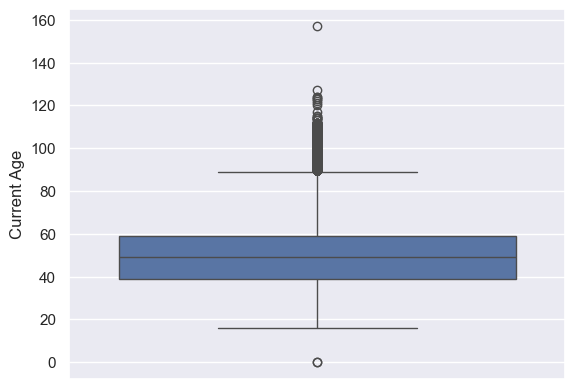

In [22]:
sns.boxplot(data[(data['Company Status']=='A') & (data['Appointment Type']==1)]['Current Age'])

In [58]:
# data[data['Current Age'] > 100]
data[(data['Company Status']=='D') & (data['Current Age'] > 120)].sort_values('Current Age', ascending=False)

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
2044174,2331194,0,2008-06-30,NaN,1692-03-01,D,D-HOLD LIMITED,MR GUY JONATHAN MCCARTHY,332.0,16.0,NaN,NaN
14435289,8239793,1,2012-10-04,NaN,1693-12-01,D,KRZYS LTD,MR KRZYSZTOF STRZESNIEWSKI,331.0,12.0,NaN,NaN
12440303,7000851,1,2009-08-26,NaN,1699-10-01,D,BOSAMP TRADING LTD,SAMSON ONWIONOKO,325.0,15.0,NaN,NaN
13041527,7362737,1,2010-09-10,NaN,1709-04-01,D,DIGIDREAM LIMITED,MR. TIMOTHEUS VERHEYEN,315.0,14.0,NaN,NaN
25749183,OC329497,4,2007-07-02,NaN,1790-05-01,D,CANAAN INVESTMENTS LLP,KIKELOMO ODELEYE,234.0,17.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
60214,224284,1,1991-09-12,NaN,1903-02-01,D,WILLIS & BATES LIMITED,MRS CARMEN OLGA BATES,121.0,33.0,NaN,NaN
61262,227143,0,1991-01-31,NaN,1903-10-01,D,FRANK MORRALL & SON LIMITED,EDITH MORRALL,121.0,33.0,NaN,NaN
61263,227143,1,1991-01-31,NaN,1903-10-01,D,FRANK MORRALL & SON LIMITED,EDITH MORRALL,121.0,33.0,NaN,NaN
69062,246733,1,1991-07-14,NaN,1903-05-01,D,HARRY WILKES AND SONS (BUILDERS) LIMITED,JEANETTA LILIAN WILKES,121.0,33.0,NaN,NaN


In [24]:
data[~data['Resignation Date'].isnull()]

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure


In [32]:
data[data['Company Number'] == 12383]

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
1447,12383,0,2016-11-07,NaN,NaT,A,SHIRE HORSE SOCIETY.(THE),VICTORIA CLAYTON,NaN,8.0,NaN,NaN
1448,12383,1,2024-03-08,NaN,1981-08-01,A,SHIRE HORSE SOCIETY.(THE),DAVID CLARKE,43.0,0.0,NaN,NaN
1449,12383,1,2022-11-15,NaN,1968-11-01,A,SHIRE HORSE SOCIETY.(THE),MR JAMES HICK,56.0,2.0,NaN,NaN
1450,12383,1,2022-11-15,NaN,1961-12-01,A,SHIRE HORSE SOCIETY.(THE),MR SIMON LIVESEY,63.0,2.0,NaN,NaN
1451,12383,1,2024-03-08,NaN,1867-10-01,A,SHIRE HORSE SOCIETY.(THE),HUW MURPHY,157.0,0.0,NaN,NaN
1452,12383,1,2024-03-08,NaN,1982-11-01,A,SHIRE HORSE SOCIETY.(THE),JOHN ROBINSON,42.0,0.0,NaN,NaN
1453,12383,1,2021-12-14,NaN,1953-04-01,A,SHIRE HORSE SOCIETY.(THE),MRS HELEN MAUREEN THOMAS,71.0,2.0,NaN,NaN
1454,12383,1,1991-12-31,NaN,1942-01-01,A,SHIRE HORSE SOCIETY.(THE),MR THOMAS JAMES YATES,82.0,32.0,NaN,NaN


In [25]:
data[data['Person Name'].str.contains(r"JAMES.*GIBBINS", case=False, na=False)]

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
180543,483521,0,1991-07-16,NaN,1955-01-01,D,J.W.PELLING LIMITED,MR MICHAEL JAMES GIBBINS,69.0,33.0,NaN,NaN
180544,483521,1,1991-07-16,NaN,1955-01-01,D,J.W.PELLING LIMITED,MR MICHAEL JAMES GIBBINS,69.0,33.0,NaN,NaN
915094,1416151,0,2012-01-31,NaN,NaT,A,CLIMBERS' SHOP LIMITED(THE),MR RAYMOND JAMES GIBBINS,NaN,12.0,NaN,NaN
2617827,2624120,0,1991-06-26,NaN,1967-09-01,D,C.I.S. INTERNATIONAL LIMITED,MR JONATHAN JAMES GIBBINS,57.0,33.0,NaN,NaN
2747288,2673102,1,2000-01-01,NaN,1965-02-01,A,GIBBINS & WILDING LIMITED,MR MICHAEL JAMES GIBBINS,59.0,24.0,NaN,NaN
2747504,2673180,1,2000-01-01,NaN,1965-02-01,A,TRUCK & BUS BUILDER PUBLISHING LIMITED,MR MICHAEL JAMES GIBBINS,59.0,24.0,NaN,NaN
3000701,2770113,1,1993-02-15,NaN,1948-11-01,D,GILTBECK LIMITED,MR STEPHEN JAMES GIBBINS,76.0,31.0,NaN,NaN
3162369,2832699,1,1993-07-06,NaN,1956-04-01,D,BUSINESS & CORPORATE LEASING LIMITED,MR ANDREW JAMES GIBBINS,68.0,31.0,NaN,NaN
3162376,2832703,1,1993-07-27,NaN,1956-04-01,D,JAGUAR RENTALS LIMITED,MR ANDREW JAMES GIBBINS,68.0,31.0,NaN,NaN
3188601,2842954,1,1993-08-06,NaN,1963-06-01,D,TEMPLE BAR DEVELOPMENTS LIMITED,ROLAND JAMES GIBBINS,61.0,31.0,NaN,NaN


In [26]:
data[data['Person Name'].str.contains("GIBBINS", case=False, na=False)][data['Partial Date of Birth'].dt.year == 1992]

C:\Users\jgibb\AppData\Local\Temp\ipykernel_20960\1921717921.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Person Name'].str.contains("GIBBINS", case=False, na=False)][data['Partial Date of Birth'].dt.year == 1992]


,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
8038982,4899448,1,2024-05-10,NaN,1992-09-01,A,HIGH-TEK SCAFFOLDING LIMITED,MR MAX MARKUS GIBBINS,32.0,0.0,NaN,NaN
8079668,4917873,1,2022-12-14,NaN,1992-09-01,A,HIGH-TEK SCAFFOLDING (BOURNEMOUTH) LIMITED,MR MAX MARKUS GIBBINS,32.0,1.0,NaN,NaN
14040349,7986149,1,2012-03-12,NaN,1992-08-01,D,IFO TRADING LTD,MR SAMUEL DONALD GIBBINS,32.0,12.0,NaN,NaN
15308058,8811285,1,2013-12-11,NaN,1992-08-01,A,PRODIS SOLUTIONS LTD,MR SAMUEL DONALD GIBBINS,32.0,11.0,NaN,NaN
22896174,14181098,1,2022-06-19,NaN,1992-09-01,A,HIGH-TEK HIRE SERVICES LTD,MR MAX MARKUS GIBBINS,32.0,2.0,NaN,NaN
23712926,14780851,1,2023-04-04,NaN,1992-09-01,D,THE COMPOSITE AND VERANDA CO. LTD,MR MAX MARKUS GIBBINS,32.0,1.0,NaN,NaN
25187083,15877359,1,2024-08-05,NaN,1992-09-01,A,HOME OAK DEVELOPMENTS LTD,MR MAX MARKUS GIBBINS,32.0,0.0,NaN,NaN


In [55]:
# unique_company_numbers = data['Company Number'].unique()
print(f'{unique_company_numbers[:5]}... ({len(unique_company_numbers)})')
# np.savetxt('unique_company_ids.csv', unique_company_numbers, delimiter=",", fmt='%s')
# unique_company_ids = np.loadtxt('unique_company_ids.csv', dtype=int)

[6 58 86 118 121]... (14239717)


In [33]:
data[data.duplicated()]

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
34788,152062,0,2009-10-31,NaN,NaT,D,ROBOT NO. 4 LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
48785,191751,1,2019-04-08,NaN,1976-08-01,D,REG VARDY (AMC) LIMITED,MR MARK SIMON WILLIS,48.0,5.0,NaN,NaN
56257,213567,1,2023-09-06,NaN,1959-12-01,A,THE CARSHALTON COURTS COMPANY LIMITED,MR KEVIN RICHARD POWER,65.0,1.0,NaN,NaN
57415,216761,1,2010-09-10,NaN,1966-06-01,D,YASDAN LIMITED,MR ROGER CHRISTOPHER HARRINGTON,58.0,14.0,NaN,NaN
64717,236303,1,2020-11-01,NaN,1978-12-01,A,UNITED KINGDOM TOBACCO COMPANY LIMITED(THE),MR CHRISTIAN MARK WOOLFENDEN,46.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
26071174,OC445050,4,2024-07-03,NaN,1985-04-01,A,CLASSTUTOR PARTNERSHIP LLP,MISS LAETITIA AFFOYA DESSOU,39.0,0.0,NaN,NaN
26071243,OC445050,4,2024-06-16,NaN,2005-07-01,A,CLASSTUTOR PARTNERSHIP LLP,MISS TEJASWINI RAJ MOHAN,19.0,0.0,NaN,NaN
26072198,OC445370,4,2023-06-30,NaN,NaT,A,MOORE KINGSTON SMITH GROUP HOLDINGS LLP,MEMBERS COMPANY 2023 LIMITED AS TRUSTEE FOR ...,NaN,1.0,NaN,NaN
26075327,OC446431,5,2023-03-21,NaN,1994-08-01,D,IT TECHNOLGY LLP,MR IBRAHIM ALKHALAF,30.0,1.0,NaN,NaN


In [35]:
data[data['Person Name'].str.contains(r"MISS SARAH LOUISE MORTON", case=False, na=False)]

,Company Number,Appointment Type,Appointment Date,Resignation Date,Partial Date of Birth,Company Status,Company Name,Person Name,Current Age,Current Tenure,Time Since Leaving,Total Tenure
34787,152062,0,2009-10-31,NaN,NaT,D,ROBOT NO. 4 LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
34788,152062,0,2009-10-31,NaN,NaT,D,ROBOT NO. 4 LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
43622,176811,0,2009-10-31,NaN,NaT,D,BLADES EAST AND BLADES LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
73892,259138,0,2009-10-31,NaN,NaT,D,MCT (EXPORT) LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
74952,261879,0,2009-10-31,NaN,NaT,D,ROBOT NO. 5 LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
111441,353187,0,2009-10-31,NaN,NaT,D,ROBOT NO. 2 LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
234889,562908,0,2009-10-31,NaN,NaT,D,WADDINGTONS BUSINESS FORMS (CLAYTON WEST) LIMI...,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN
1479400,1946674,0,2009-10-31,NaN,NaT,D,ROBOT NO. 8 LIMITED,MISS SARAH LOUISE MORTON,NaN,15.0,NaN,NaN


In [47]:
# update_file = 'Prod198_3850.txt'

# person_record_colspecs = [ (0,8), (15,17), (17,19), (43,51), (75,83), (83,91), (111,1249) ]
# person_record_names = [ "Company Number", "Old Appointment Type", "New Appointment Type", "Partial Date of Birth", "Appointment Date", "Resignation Date", "Variable Data" ]
# company_record_colspecs = [ (0,8), (9,10), (40,201) ]
# company_record_names = [ "Company Number", "Company Status", "Company Name" ]

# def detect_colspec(line):
#     if line[8] == '1':
#         return company_record_colspecs, company_record_names
#     elif line[8] == '2':
#         return person_record_colspecs, person_record_names
#     else:
#         print(line)
#         return [],[]

# def process_entire_file(file_path):
#     company_records = []
#     person_records = []

#     with open(file_path, 'r') as file:
#         for line in tqdm(file, desc="Processing lines", mininterval=1):
#             colspecs, names = detect_colspec(line)
#             if colspecs != []:
#                 parsed_line = pd.read_fwf(pd.io.common.StringIO(line), colspecs=colspecs, names=names)
#                 if "Company Status" in names:
#                     company_records.append(parsed_line)
#                 else:
#                     person_records.append(parsed_line)

#     # Convert to DataFrames
#     print(f'{pd.Timestamp.now()}: Converting to DataFrames')
#     df_company = pd.concat(company_records, ignore_index=True) if company_records else pd.DataFrame(columns=company_record_names)
#     df_person = pd.concat(person_records, ignore_index=True) if person_records else pd.DataFrame(columns=person_record_names)

#     return df_company, df_person

# if "update_data" not in globals():
#     update_data = pd.DataFrame()

# df_company, df_person = process_entire_file(update_file)

# print(f'{pd.Timestamp.now()}: Merging new data')
# new_data = pd.merge(df_person, df_company, on="Company Number", how="inner")

# print(f'{pd.Timestamp.now()}: Cleaning data')
# new_data['Company Status'] = new_data['Company Status'].fillna('A')
# new_data['Person Name'] = new_data['Variable Data'].str.split('<<<<').str[0].str.replace('<',' ')
# new_data['Company Name'] = new_data['Company Name'].str.replace('<',' ')
# new_data = new_data.drop(['Variable Data'], axis=1)

# print(f'{pd.Timestamp.now()}: Making new columns')
# new_data['Partial Date of Birth'] = pd.to_datetime(new_data['Partial Date of Birth'].dropna().astype(int).astype(str), format='%Y%m', errors='coerce')
# new_data['Appointment Date'] = pd.to_datetime(new_data['Appointment Date'].astype(int).astype(str), format='%Y%m%d', errors='coerce')
# new_data['Resignation Date'] = pd.to_datetime(new_data['Resignation Date'].fillna(30000101).astype(int).astype(str), format='%Y%m%d', errors='coerce')
# today = pd.Timestamp.now()
# new_data['Current Age'] = new_data['Partial Date of Birth'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)) if pd.notnull(x) else np.nan)
# def calculate_tenure(row):
#     if pd.isnull(row['Resignation Date']):
#         current_tenure = today.year - row['Appointment Date'].year - ((today.month, today.day) < (row['Appointment Date'].month, row['Appointment Date'].day))
#         return pd.Series({'Current Tenure': current_tenure, 'Time Since Leaving': np.nan, 'Total Tenure': np.nan})
#     else:
#         time_since_leaving = today.year - row['Resignation Date'].year - ((today.month, today.day) < (row['Resignation Date'].month, row['Resignation Date'].day))
#         total_tenure = (row['Resignation Date'] - row['Appointment Date']).days / 365.25  # Total tenure in years
#         return pd.Series({'Current Tenure': np.nan, 'Time Since Leaving': time_since_leaving, 'Total Tenure': total_tenure})
# new_data[['Current Tenure', 'Time Since Leaving', 'Total Tenure']] = new_data.apply(calculate_tenure, axis=1)

# print(f'{pd.Timestamp.now()}: Merging data')
# update_data = pd.concat([update_data, new_data], ignore_index=True)

Processing lines: 0it [00:00, ?it/s]

DDDDUPDT385020241212



Processing lines: 20326it [00:27, 727.15it/s]

9999999900020324

2024-12-13 09:53:40.066802: Converting to DataFrames


2024-12-13 09:53:44.296534: Merging new data
2024-12-13 09:53:44.313619: Cleaning data
